# Image Segmentation using CNNs

## Data
900 labeled Image(.jpg),GroundTruth(.png) pairs.

## Architecture

I'm using the Unet Architecture as described the paper [here](https://arxiv.org/pdf/1505.04597.pdf).<br/>
The tensorflow implementation of the same is found [here](https://github.com/jakeret/tf_unet).<br/>
Keras implememtation [here](https://github.com/jocicmarko/ultrasound-nerve-segmentation).<br/>
I'll be using the tensorflow implemetation.

## Preprocessing

+ **The tf_unet package requires having both the Input and groundtruth images in the same folder. **

  I wrote a simple [shell script](https://gist.github.com/kaushiksk/cea2b001666f4fe100b2ba31afea3eb0#file-script-sh) to create a 600-300 split and added corresponding input and groundtruth images to the **train/** and **test/** folders.


+ **The tf_unet package requries having all images of the same height and width to be fed into the network**

  I used ImageMagick's mogrify tool for this.
  
  ```
  $ mogrify -resize 900*700! *.jpg
$ mogrify -resie 900*700! *.png
  ```
  
  I discared one image from the training set as it's size was smaller than this. That left me with 599 training images and 300 test images of size 900\*700.
  
 

## Converting Images to greyscale
From the last experiment it was clear that the classification was biased towards the red channel, here I convert all input images to greyscale because all necessary informationcan in fact be captured in a sinvle channel.

In [ ]:
# convert_to_grey.py
# The following script is run both in the train/ and the test/ folder
from PIL import Image
import glob

imgs = glob.glob("*.jpg")

for file in imgs:
    img =  Image.open(file).convert('L')
    filename = file.split('.')[0] + "_gray.jpg"
    img.save(filename)



## Training

I made a few changes to the model, increasing the depth and root features and limiting inputs to a single channel

tf_unet docs are available [here](http://tf-unet.readthedocs.io/en/latest/). 


In [65]:
#imports
from tf_unet import unet, util, image_util

# this is a helper object provided by the module to feed data to the network. The parameters are self explanatory
# docs : http://tf-unet.readthedocs.io/en/latest/tf_unet.html#tf_unet.image_util.ImageDataProvider

data_provider = image_util.ImageDataProvider("./train/train/*",data_suffix="gray.jpg",mask_suffix="Segmentation.png")

output_path = "./model_val_20_epochs/"

#setup & training
net = unet.Unet(layers=4, features_root=32, channels=1, n_class=2)
trainer = unet.Trainer(net)
path = trainer.train(data_provider, output_path, training_iters=32, epochs=20,restore=True)


2017-07-17 11:45:16,867 Layers 4, features 32, filter size 3x3, pool size: 2x2


Number of files used: 599


### Training Contd.

I put the above code in a .py file and ran it for about 20 epochs.<br/>


## Testing

I interrupted training multiple times to observe what was being output by the network. Read through the source code extensively as well.

The model output a greyscale image which was just the "white" predictions scaled to 255.

Each pixel was a binary softmax of the type [black_prob, white_prob] 

In [66]:
# Retrive one test example
# Retrive stored model (This is saved after training automatically)
# predict on the test input

x_test, y_test = data_provider(1)
path = "./model_val_20_epochs/model.cpkt"
prediction = net.predict(path, x_test)

INFO:tensorflow:Restoring parameters from ./model_val_20_epochs/model.cpkt


2017-07-17 11:45:25,536 Restoring parameters from ./model_val_20_epochs/model.cpkt
2017-07-17 11:45:25,773 Model restored from file: ./model_val_20_epochs/model.cpkt


In [67]:
x_test.shape,y_test.shape,prediction.shape

((1, 700, 900, 1), (1, 700, 900, 2), (1, 612, 812, 2))

The output prediction is indeed smaller than the input images. This is due to the various levels of convolution.<br/>
Error is calculated in the model by cropping the groundtruth to the size of predicted image, and then comparing the white channel of the groundtruth with the argmax(pixelwise softmax) of the predicted image.

The model does internal processing of the groundtruth images to represent each pixel as [1,0] or [0,1].

###### I played around with the output here a lot and came up with the below helper functions to represent and predict the ouput on the entire training set.

#### I also tried different thresholds for the output image and found that 0.5 gave the best results

In [28]:
x_test[0,...,-1].shape

(700, 900)

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
import tensorflow as tf

In [12]:
# Returns the next test_x, test_y pair
# This is just a slightly modified version of the function in the source code

def getnext(data_provider):
    data, label = data_provider._next_data()

    train_data = data_provider._process_data(data)
    labels = data_provider._process_labels(label)

    train_data, labels = data_provider._post_process(train_data, labels)

    nx = data.shape[1]
    ny = data.shape[0]

    return train_data.reshape(1, ny, nx, data_provider.channels), labels.reshape(1, ny, nx, data_provider.n_class)

In [70]:
# function to store images in two folders respectively depending on the accuracy

def visualize(x_test,y_test,prediction,i,err=False):
    
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12,5))
    
    ax[0].imshow(x_test[0,...,-1], aspect="auto", cmap="gray") #input
    ax[1].imshow(y_test[0,...,1], aspect="auto",cmap="gray") #groundtruth
    ax[2].imshow(prediction[0,...,1], aspect="auto",cmap="gray") #prediciton
        
    mask = ((prediction[0,..., 1]>=0.4).astype('float32')*255).astype(np.uint8) # applying threshold on white channel of prediction
    ax[3].imshow(mask, aspect="auto",cmap="gray")
    
    ax[0].set_title("Input")
    ax[1].set_title("Ground truth")
    ax[2].set_title("Prediction")
    ax[3].set_title("Prediction > 0.4")
    fig.tight_layout()
    
    if err:
        fig.savefig("./outliers/pred_{}.png".format(i))
    else:
        fig.savefig("./bestfits/pred_{}.png".format(i))   
    plt.close()

Run the below line to see what the function does. It basically puts together images side by side and saves them as a single image.

In [71]:
visualize(x_test,y_test,prediction,1)

<img src="./bestfits/pred_1.png">

### Evaluation on training set

I use the same improvememt I used in the previous experiment for evaluations.

### Overwriting the inbuilt functions

I went through the netire source code at this point to know where exactly I had to make changes. I realised I could fix the overhead computations by changing just two functions and then running things inside my own session.


In [37]:
from tf_unet.unet import *

In [38]:
# Inheriting the unet.Unet class and overriding a few functions.
# source code : http://tf-unet.readthedocs.io/en/latest/_modules/tf_unet/unet.html#Unet

class myUnet(unet.Unet):


    def predict(self, sess, model_path, x_test,restore=True):
        """
        Uses the model to create a prediction for the given data
        
        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, channels]
        :returns prediction: The unet prediction Shape [n, px, py, labels] (px=nx-self.offset/2) 
        """

        # Restore model weights from previously saved model before calling this

        y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
        prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})
            
        return prediction


    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint
        
        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)


Now good to go. Change of metric and change of way of representing the ouput as well. <br/>
I decided it would help to display the difference between the predicted and groundtruth images in black and white as this would allow me to see exactly which pixels were being classified wrongly.

### Strategy 
1. Get the predicted image.
2. Extract the white channel
3. With threshold of 0.5 classify as either 1 or 0
4. Extract white channel from groundtruth
5. Crop groundtruth down to the size of predicted image (in-built function)
6. Compute accuracy via dice-coefficient
7. diff = (predicted!=cropped_ground_truth) i.e white pixels in this image are the one's that were classified wrongly

In [83]:
# Helper function to save concatenated images (input,groundtruth,predicted(with threshold), diff)

def save_img(data_x,white_y,white,diff,name):
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14,5))
    ax[0].imshow(data_x[0,...,-1], aspect="auto", cmap="gray")
    ax[1].imshow(white_y[0], aspect="auto",cmap="gray")
    ax[2].imshow(white[0], aspect="auto",cmap="gray")
    ax[3].imshow(diff[0], aspect="auto",cmap="gray")
    ax[0].set_title("Input")
    ax[1].set_title("GroundTruth")
    ax[2].set_title("Prediction>0.5")
    ax[3].set_title("diff")
    fig.tight_layout()
    fig.savefig(name)
    plt.close()

In [58]:
def dice_coeff(pred,y):
    pred = pred.reshape(-1,1).astype(np.bool)
    y = y.reshape(-1,1).astype(np.bool)
    
    intersection = np.logical_and(pred,y)
    return 2. * intersection.sum() / (pred.sum()+y.sum())
    

In [82]:
# this is where the testing happens

def make_predictions(data_provider, outdir,
                     save=True, verbose=False,
                     printevery=40,
                     path = "./model_val_50_epochs/model.cpkt"): 
    

    
    
    #initialise network. Observe we are using our cutsom myUnet Class
    net = myUnet(layers=4, features_root=32, channels=1, n_class=2)
    
    import os
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    # start tensorflow session
    with tf.Session() as sess:
    
        # Initialize variables
        init = tf.global_variables_initializer()
        sess.run(init)
        
        # Restore parameters
        net.restore(sess, path)
        
        accuracy= []
        
        print("Printing Mean Accuracy every", printevery,"inputs.")
        print("Proccessed : Mean Accuracy")

        for i in range(len(data_provider.data_files)):
            
            # get next x,y pair
            x_train,y_train = getnext(data_provider)
            
            #predict
            prediction = net.predict(sess, path, x_train)
            
            #apply threshold
            prediction = ((prediction[...,1]>=0.5).astype('float32')).astype(np.uint8)
            
            # crop groundtruth
            y_cropped = util.crop_to_shape(y_train[...,1], prediction.shape)

            #New accuracy metric, % of pixels that match in both
            # acc = np.sum(prediction==y_cropped)/(prediction.shape[0]*prediction.shape[1]*prediction.shape[2])
            
            #dice-coefficient
            acc = dice_coeff(prediction[0],y_cropped[0])            

            accuracy.append(acc)
            
            # diff
            diff =  ((prediction!=y_cropped).astype('float32')*255).astype(np.uint8)
            
            # Scale to 255 to display as grayscale
            prediction = prediction*255
            y_cropped=y_cropped*255
            
            #filename : files will be sorted according to accuracy
            name = outdir+str(acc)[:4]+"pred"+str(i)+".png"
            
            if save:
                save_img(x_train, y_cropped, prediction,diff,name)
            if verbose:
                print("{0:>4}:\t{1}".format(i,acc))
            elif (i+1)%printevery == 0 or i==len(data_provider.data_files)-1:
                print("{0:>4}:\t{1}".format(i+1,np.mean(accuracy)))
                
        
        sess.close()
        return accuracy


In [84]:
# generator objects for train and test data

train_data_provider = image_util.ImageDataProvider("./train/train/*",data_suffix="gray.jpg",mask_suffix="Segmentation.png")
test_data_provider = image_util.ImageDataProvider("./test/test/*",data_suffix="gray.jpg",mask_suffix="Segmentation.png")


Number of files used: 599
Number of files used: 300


## Time for proper testing!!


In [85]:
train_accuracy = make_predictions(train_data_provider,"./pred/train_pred_dice/",save=True)

2017-07-17 11:58:30,535 Layers 4, features 32, filter size 3x3, pool size: 2x2


INFO:tensorflow:Restoring parameters from ./model_val_50_epochs/model.cpkt


2017-07-17 11:58:36,676 Restoring parameters from ./model_val_50_epochs/model.cpkt
2017-07-17 11:58:36,878 Model restored from file: ./model_val_50_epochs/model.cpkt


Printing Mean Accuracy every 40 inputs.
Proccessed : Mean Accuracy
  40:	0.6545202034054005
  80:	0.6402034518354464
 120:	0.6359928063195694
 160:	0.6341383334538531
 200:	0.6233331919255964
 240:	0.6270858860924589
 280:	0.6341078493999311
 320:	0.6455722759868656
 360:	0.646517891658188
 400:	0.6396729157047477
 440:	0.6400368676589882
 480:	0.6414416915816721
 520:	0.6450608615408485
 560:	0.6418905066460421
 599:	0.6463811461730673


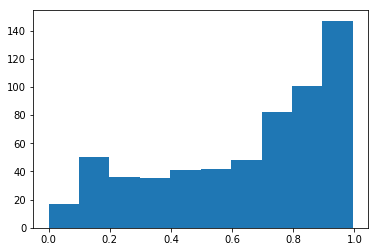

In [86]:
train_accuracy = np.asarray(train_accuracy)
a,b,hist = plt.hist(train_accuracy,bins=10)

In [87]:
# helper function to view actual counts in histogram
def histdata(accuracy):
    numvalues, x = np.histogram(accuracy, bins=np.arange(0,1.1,0.1))
    print("Accuracy  :   No. of predictions\n")
    for i in range(len(numvalues)):
        print("{:03.1f} - {:03.1f} : {:>4}".format(x[i],x[i+1],numvalues[i]))

In [88]:
histdata(train_accuracy)

Accuracy  :   No. of predictions

0.0 - 0.1 :   17
0.1 - 0.2 :   50
0.2 - 0.3 :   37
0.3 - 0.4 :   34
0.4 - 0.5 :   42
0.5 - 0.6 :   45
0.6 - 0.7 :   44
0.7 - 0.8 :   88
0.8 - 0.9 :  101
0.9 - 1.0 :  141


In [89]:
print("Mean Accuracy:",np.mean(train_accuracy))
print("Accuracy > 0.8 :", np.mean(train_accuracy>=0.8)*100,"%")

Mean Accuracy: 0.646381146173
Accuracy > 0.8 : 40.4006677796 %


#### The model predicts 64.63% of the pixels correctly per image. 


## Let's visualise a bit more!

## Now on the test set

In [90]:
test_accuracy = make_predictions(test_data_provider,"./pred/test_pred_dice/",save=True)

2017-07-17 14:39:17,858 Layers 4, features 32, filter size 3x3, pool size: 2x2


INFO:tensorflow:Restoring parameters from ./model_val_50_epochs/model.cpkt


2017-07-17 14:39:24,134 Restoring parameters from ./model_val_50_epochs/model.cpkt
2017-07-17 14:39:24,826 Model restored from file: ./model_val_50_epochs/model.cpkt


Printing Mean Accuracy every 40 inputs.
Proccessed : Mean Accuracy
  40:	0.6126622799152859
  80:	0.6029529290574199
 120:	0.6141805412575029
 160:	0.6078714718116836
 200:	0.6052577679677759
 240:	0.6145155095454353
 280:	0.6224489263093678
 300:	0.6241777392384148


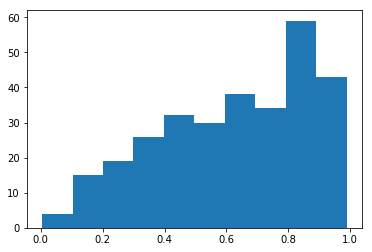

In [91]:
test_accuracy = np.asarray(test_accuracy)
a,b,hist = plt.hist(test_accuracy,bins=10)

In [92]:
histdata(test_accuracy)

Accuracy  :   No. of predictions

0.0 - 0.1 :    4
0.1 - 0.2 :   15
0.2 - 0.3 :   19
0.3 - 0.4 :   26
0.4 - 0.5 :   33
0.5 - 0.6 :   32
0.6 - 0.7 :   38
0.7 - 0.8 :   35
0.8 - 0.9 :   55
0.9 - 1.0 :   43


In [93]:
print("Mean Accuracy:",np.mean(test_accuracy))
print("Accuracy > 0.8 :", np.mean(test_accuracy>=0.8)*100,"%")

Mean Accuracy: 0.624177739238
Accuracy > 0.8 : 32.6666666667 %
